<a href="https://colab.research.google.com/github/hairulysin/Machine_Learning_Project/blob/main/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hairul Yasin

Import Library yang dibutuhkan

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('/content/NFLX.csv', parse_dates=['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [ ]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df.shape

(1009, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1009 non-null   datetime64[ns]
 1   Open       1009 non-null   float64       
 2   High       1009 non-null   float64       
 3   Low        1009 non-null   float64       
 4   Close      1009 non-null   float64       
 5   Adj Close  1009 non-null   float64       
 6   Volume     1009 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 55.3 KB


Plot Unit yang Terjual

Text(0.5, 1.0, 'Unit yang terjual')

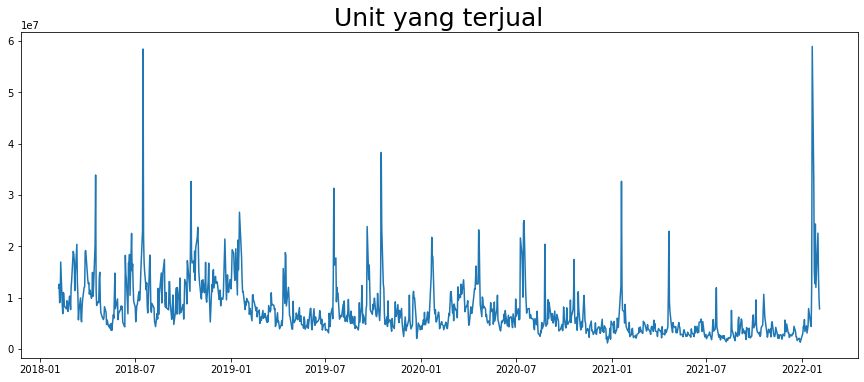

In [ ]:
dates = df['Date'].values
volume = df['Volume'].values

plt.figure(figsize=(15,6))
plt.plot(dates, volume)
plt.title('Unit yang terjual', fontsize=25)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')


In [ ]:
volume = volume.reshape(-1,1)
volume

array([[11896100],
       [12595800],
       [ 8981500],
       ...,
       [14346000],
       [ 9905200],
       [ 7782400]])

In [ ]:
scaler = MinMaxScaler()
volume = scaler.fit_transform(volume)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(volume, dates,
                                                    test_size=0.2,
                                                    shuffle=False)


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(X_test, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set  = windowed_dataset(X_train, window_size=60, batch_size=32, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True, input_shape = [None, 1]),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:

threshold_mae = (volume.max() - volume.min()) * 10/100
print("Batas maksimal nilai mae (10%) dari data adalah sebesar", threshold_mae)

Batas maksimal nilai mae (10%) dari data adalah sebesar 0.1


In [ ]:
class myCallback(tf.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs={}): 
    if(logs.get('mae') < threshold_mae): 
      print("MAE < 10%") 
      self.model.stop_training = True 
callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,
                    epochs=50,
                    validation_data=test_set,
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/50
MAE < 10%
2/2 - 5s - loss: 0.0079 - mae: 0.0657 - val_loss: 0.0095 - val_mae: 0.1051 - 5s/epoch - 3s/step
